# Training Czech Sentiment Analysis Model

This notebook walks through the complete process of fine-tuning the ELECTRA model for Czech sentiment classification.

**Goal**: Train a classifier that can predict sentiment (negative/neutral/positive) for Czech Facebook comments.

**Steps**:
1. Load and explore the labeled data
2. Split into train/validation/test sets
3. Prepare the ELECTRA model and tokenizer
4. Create PyTorch datasets
5. Train the model
6. Evaluate performance
7. Save the trained model

## Step 4: Create PyTorch Dataset

**What's a Dataset?**
A PyTorch Dataset is a wrapper that:
1. Takes raw text and labels
2. Tokenizes the text (splits into subwords, converts to IDs)
3. Adds padding and special tokens ([CLS], [SEP])
4. Returns PyTorch tensors ready for training

**Key parameters**:
- `max_length=128`: Truncate/pad all comments to 128 tokens (balances speed vs. information retention)
- `padding="max_length"`: All sequences same length (required for batching)
- `truncation=True`: Cut off text longer than 128 tokens

### Understanding Your Configuration

Let's verify the batching and worker settings are optimal for your hardware.

## Step 6: Configure Training

**Training hyperparameters explained**:

- **Epochs (3)**: How many times the model sees the entire training set
  - Too few = underfitting (model doesn't learn enough)
  - Too many = overfitting (model memorizes training data)
  
- **Learning rate (2e-5)**: How big of a step the optimizer takes when updating weights
  - Too high = model doesn't converge
  - Too low = training takes forever
  - 2e-5 is a good default for fine-tuning transformers

- **Warmup steps**: Gradually increase learning rate from 0 to 2e-5 in the first 10% of training
  - Helps stabilize training at the start

- **AdamW optimizer**: Modern version of Adam that handles weight decay better (prevents overfitting)

In [40]:
# Training configuration
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (warmup + linear decay)
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Training configuration:")
print(f"- Epochs: {EPOCHS}")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Total training steps: {total_steps:,}")
print(f"- Warmup steps: {warmup_steps:,}")
print(f"- Device: {device}")

Training configuration:
- Epochs: 3
- Learning rate: 2e-05
- Batch size: 16
- Total training steps: 1,314
- Warmup steps: 131
- Device: mps


### Deep Dive: Why These Hyperparameters?

Let's understand the theory and trade-offs behind each choice.

## 1️⃣ EPOCHS = 3

**What it means:**
- The model will see the entire training dataset 3 times
- Each pass through all data = 1 epoch = 438 batches = 438 gradient updates

**Why 3 epochs?**

The key insight: **ELECTRA is already pre-trained**. It already understands Czech language structure, grammar, and semantics. We're just teaching it to map that knowledge to 3 sentiment categories.

**The Learning Curve:**

```
Epoch 1: Model learns basic sentiment patterns
         "děkuji" → positive, "hrozné" → negative
         
Epoch 2: Model learns nuanced patterns
         "ale aspoň..." → conditional sentiment
         Context-dependent expressions
         
Epoch 3: Model fine-tunes decision boundaries
         Edge cases, subtle tone differences
         
Epoch 4+: Risk of OVERFITTING
         Model starts memorizing training data
         Validation accuracy stops improving or decreases
```

**Alternative epoch counts:**

| Epochs | When to use | Risk |
|--------|-------------|------|
| 1-2    | Very large dataset (>100k samples) | Underfitting - model doesn't learn enough |
| **3-5** | **Standard for fine-tuning (our case)** ✅ | Balanced |
| 6-10   | Small dataset (<1k samples) + strong regularization | Overfitting - memorizes training set |
| 10+    | Training from scratch (NOT fine-tuning) | Severe overfitting for fine-tuning |

**How to know the right number:**
- Watch validation loss/accuracy
- Stop when validation stops improving (early stopping)
- Rule of thumb: If val_loss increases for 2 consecutive epochs → STOP

**Mathematical intuition:**
```
Total gradient updates = epochs × batches_per_epoch
Our case: 3 × 438 = 1,314 updates

Each update slightly adjusts 13M parameters
Too few updates → weights barely change from pre-trained values
Too many updates → weights drift too far, forgetting pre-trained knowledge
```

## 2️⃣ LEARNING_RATE = 2e-5 (0.00002)

**What it means:**
After computing gradients, we update weights by:
```
new_weight = old_weight - learning_rate × gradient
```

**Why 2e-5 is "just right" for fine-tuning:**

Think of learning rate as step size when walking down a hill (gradient descent):

```
Too small (1e-7):           Optimal (2e-5):         Too large (1e-3):
    🚶                          🏃                       🤸
    |                           |                        |
    Tiny steps                  Balanced                Giant leaps
    Takes forever               Converges well          Overshoots minimum
    Stuck in local minima       Finds good solution     Unstable/diverges
```

**The Fine-tuning Principle:**

When training from scratch: Use lr = 1e-3 to 1e-4 (large steps needed)
When fine-tuning: Use lr = 1e-5 to 5e-5 (small steps to preserve pre-trained knowledge)

**Why smaller for fine-tuning?**
1. Pre-trained weights are already near optimal for language understanding
2. We only need small adjustments for the new task
3. Large steps would "forget" the pre-trained knowledge (catastrophic forgetting)

**The Science Behind 2e-5:**

This value comes from empirical research:
- BERT paper (2018): Recommended 2e-5 to 5e-5 for fine-tuning
- Validated across thousands of NLP tasks
- Sweet spot for 12-layer transformers

**Mathematical View:**

Imagine weights as coordinates in 13M-dimensional space:
- Pre-trained weights start at good location
- Gradient points toward sentiment-task optimum
- lr controls how far we move each step

```
Small LR (1e-6):  Move 0.000001 units → 10,000 steps to move 0.01 units
Our LR (2e-5):    Move 0.00002 units  → 500 steps to move 0.01 units ✅
Large LR (1e-3):  Move 0.001 units    → 10 steps but overshoots!
```

**Alternative learning rates:**

| Learning Rate | When to use | Expected behavior |
|---------------|-------------|-------------------|
| 1e-6 to 5e-6 | Large model (GPT-3 scale), very stable training | Slow but safe |
| 1e-5 to 3e-5 | Fine-tuning transformers (base/large), high-quality data | Standard choice |
| **2e-5** | **BERT/ELECTRA base models (our case)** ✅ | Proven optimal |
| 5e-5 to 1e-4 | Small models, noisy data, more epochs available | Faster but riskier |
| 1e-4 to 1e-3 | Training from scratch, early stage exploration | Too aggressive for fine-tuning |

**How to choose experimentally:**

1. **Grid Search** (expensive but thorough):
   ```python
   lr_candidates = [1e-5, 2e-5, 3e-5, 5e-5]
   for lr in lr_candidates:
       train_model(lr=lr)
       compare_val_accuracy()
   ```

2. **Learning Rate Range Test** (efficient):
   ```python
   # Start with very small LR, gradually increase
   # Plot: LR vs. Loss
   # Pick LR where loss decreases fastest
   ```

3. **Use published defaults** (fastest): ✅
   - 2e-5 for BERT/ELECTRA base
   - 1e-5 for BERT/ELECTRA large
   - 5e-5 for smaller models

**Warning signs:**

```python
# LR too high:
Epoch 1: train_loss=0.8, val_loss=0.9
Epoch 2: train_loss=0.3, val_loss=1.2  ← val_loss INCREASES
→ Solution: Reduce LR by 2-5x

# LR too low:
Epoch 1: train_loss=1.1, val_loss=1.1
Epoch 2: train_loss=1.09, val_loss=1.09  ← barely improves
Epoch 3: train_loss=1.08, val_loss=1.08
→ Solution: Increase LR by 2x or add more epochs
```

## 3️⃣ WARMUP_RATIO = 0.1 (10% of training)

**What it means:**
Instead of starting at full learning rate, we gradually increase from 0 → 2e-5 over the first 10% of training.

```
Steps:    0     131    657    1,314
LR:     0.0    2e-5   1e-5     0.0
        └warmup┘└────decay────┘
         10%         90%
```

**Why warmup?**

**The Problem Without Warmup:**
```
Step 1: Pre-trained weights + Random classification head
        ↓
        Forward pass with mismatched components
        ↓
        HUGE gradients from untrained head
        ↓
        Large LR × huge gradients = DISASTER
        ↓
        Pre-trained encoder weights get corrupted
```

**The Solution With Warmup:**
```
Step 1-131: Gradual LR increase (0 → 2e-5)
            ↓
            Classification head learns basics with gentle updates
            ↓
            Encoder weights barely change (protected by small LR)
            ↓
            System stabilizes
            
Step 132+:  Full LR kicks in
            ↓
            Now both head and encoder are aligned
            ↓
            Safe to use full learning rate
```

**The Theory:**

1. **Mixed Initialization Problem:**
   - ELECTRA encoder: Pre-trained (good weights)
   - Classification head: Random initialization (bad weights)
   - Without warmup: Bad head produces bad gradients → damages good encoder

2. **Gradient Shock Prevention:**
   ```python
   # Step 1 without warmup:
   encoder_gradient = 0.5  (reasonable)
   head_gradient = 50.0    (huge! Random init)
   update = lr × gradient = 2e-5 × 50 = 0.001  (too big!)
   
   # Step 1 with warmup:
   actual_lr = 0.1 × 2e-5 = 2e-6  (10x smaller)
   update = 2e-6 × 50 = 0.0001  (safe)
   ```

3. **Adaptive Learning:**
   - Early steps: Model figures out task basics
   - Later steps: Model refines details
   - Warmup gives the model time to "understand" before committing

**Alternative warmup strategies:**

| Warmup Ratio | When to use | Pros/Cons |
|--------------|-------------|-----------|
| 0.0 (none) | Model trained from scratch, stable dataset | Fast but risky |
| 0.05-0.08 | Small datasets (<5k samples), shorter training | Minimal protection |
| **0.1** | **Standard for fine-tuning (3-5 epochs)** ✅ | Proven default |
| 0.2-0.3 | Very unstable training, mixed quality data | Extra safe but slower |
| 0.5+ | Rarely used | Too conservative |

**Warmup Steps Formula:**
```python
warmup_steps = total_steps × warmup_ratio
Our case: 1,314 × 0.1 = 131 steps

# This means:
Batch 1:   lr = 0.0
Batch 66:  lr = 1e-5  (halfway through warmup)
Batch 131: lr = 2e-5  (warmup done)
Batch 132: lr starts decaying
```

**Advanced: Warmup Schedules**

1. **Linear Warmup (what we use):** ✅
   ```
   lr = max_lr × (step / warmup_steps)
   ```
   Simple, works well for most cases

2. **Exponential Warmup:**
   ```
   lr = max_lr × (1 - exp(-step/warmup_steps))
   ```
   Slower start, faster ramp-up

3. **Constant Warmup:**
   ```
   lr = small_constant  (for first N steps)
   lr = max_lr          (after warmup)
   ```
   Abrupt transition, rarely used

**Warmup + Decay Combined:**

Our full schedule:
```python
def get_lr(step):
    if step < warmup_steps:
        # Warmup phase
        return max_lr * (step / warmup_steps)
    else:
        # Decay phase
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return max_lr * (1 - progress)  # Linear decay to 0
```

**Visualization:**
```
LR
 |
2e-5 |         ________________
     |        /                 \
     |       /                   \
     |      /                     \
     |     /                       \
0.0  |____/                         \____
     0   131  657           1,314  Steps
        warmup    decay
```

**Why not just use constant LR?**

| Approach | Behavior | Result |
|----------|----------|--------|
| Constant LR | Same step size throughout | Gets stuck near minimum, oscillates |
| Warmup only | Gentle start, then constant | Better than constant, but still oscillates |
| **Warmup + Decay** ✅ | Gentle start → confident middle → precise end | Best convergence |

**When to modify warmup:**

```python
# Increase warmup if:
- Training is unstable (loss spikes)
- Using very high learning rate
- Dataset is noisy
warmup_ratio = 0.2  # More cautious

# Decrease warmup if:
- Training from scratch (all weights random)
- Very small learning rate
- Short training (<1000 steps)
warmup_ratio = 0.05  # Less necessary

# Skip warmup if:
- Continuing training (all weights already trained)
- Using momentum-based optimizers with low LR
warmup_ratio = 0.0
```

## 4️⃣ AdamW Optimizer

**What it is:**
AdamW = **Adam** with **Decoupled Weight Decay**

Full name: Adaptive Moment Estimation with Weight Decay

**Why AdamW instead of vanilla SGD?**

| Optimizer | How it works | Pros | Cons | Use case |
|-----------|-------------|------|------|----------|
| **SGD** | `w = w - lr × gradient` | Simple, well-understood | Slow, sensitive to LR | Research, when you have time |
| **SGD + Momentum** | Adds velocity to smooth updates | Faster than SGD | Still slow | Computer vision (CNNs) |
| **Adam** | Adaptive LR per parameter | Fast, robust to LR | Uses more memory | General purpose |
| **AdamW** ✅ | Adam + proper weight decay | Best for transformers | Slightly complex | **NLP transformers** |

**The Math Behind AdamW:**

```python
# Traditional SGD:
weight = weight - learning_rate × gradient

# Adam adds two components:
# 1. Momentum (first moment): Running average of gradients
# 2. RMSprop (second moment): Running average of squared gradients

# Simplified AdamW update:
m = beta1 × m + (1 - beta1) × gradient        # Momentum
v = beta2 × v + (1 - beta2) × gradient²       # Adaptive LR
m_hat = m / (1 - beta1^t)                     # Bias correction
v_hat = v / (1 - beta2^t)                     # Bias correction
weight = weight - lr × m_hat / (sqrt(v_hat) + epsilon) - weight_decay × weight
```

**Why this works so well:**

1. **Adaptive Learning Rates:**
   ```
   Parameter with large gradients → smaller effective LR (divide by sqrt(v))
   Parameter with small gradients → larger effective LR
   
   Example:
   Word embedding for "excellent": gradient = 10
   Hidden layer weight #7531: gradient = 0.01
   
   Adam automatically uses ~100x larger LR for weight #7531
   ```

2. **Momentum Smoothing:**
   ```
   Without momentum:
   Step 1: gradient = +5  → update = +5
   Step 2: gradient = -4  → update = -4  (wasted effort!)
   Step 3: gradient = +6  → update = +6
   
   With momentum:
   Step 1: momentum = +5  → update = +5
   Step 2: momentum = +3  → update = +3  (smooth)
   Step 3: momentum = +4  → update = +4  (stable)
   ```

3. **Weight Decay (Regularization):**
   ```
   Pulls weights toward zero: weight = 0.9999 × weight
   Prevents overfitting by penalizing large weights
   AdamW does this correctly (original Adam had a bug)
   ```

**AdamW Hyperparameters:**

```python
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,           # Learning rate (we discussed)
    betas=(0.9, 0.999),  # Momentum coefficients
    eps=1e-8,          # Numerical stability
    weight_decay=0.01  # L2 regularization
)
```

**Betas explained:**

| Parameter | Default | What it controls | Alternatives |
|-----------|---------|------------------|--------------|
| `beta1` | 0.9 | First moment (momentum) decay | 0.8-0.95 (rarely change) |
| `beta2` | 0.999 | Second moment (RMSprop) decay | 0.99-0.9999 (rarely change) |

```python
# beta1 = 0.9 means:
# Keep 90% of old momentum + 10% of new gradient
# Higher beta1 = smoother updates, slower response
# Lower beta1 = faster response, noisier updates

# beta2 = 0.999 means:
# Keep 99.9% of old variance estimate + 0.1% of new
# Very slow adaptation (stable for most tasks)
```

**Weight Decay:**

```python
weight_decay=0.01  # Default for transformers

# What it does:
# Every step: weight = weight × (1 - lr × weight_decay)
# With lr=2e-5: weight = weight × 0.9998

# Effect:
weight_decay=0.0    # No regularization (may overfit)
weight_decay=0.001  # Light regularization
weight_decay=0.01   # Standard (our choice) ✅
weight_decay=0.1    # Heavy regularization (underfitting risk)
```

**Alternative Optimizers:**

| Optimizer | When to use | Key difference |
|-----------|-------------|----------------|
| **AdamW** ✅ | Fine-tuning transformers | Best for pre-trained models |
| Adam | Training from scratch | Original version (slightly worse) |
| SGD + Momentum | CNNs, ResNets | Better generalization, slower convergence |
| RMSprop | Recurrent networks | Good for RNNs |
| AdaGrad | Sparse features | Accumulates all history |
| Adafactor | Very large models (GPT-3) | Memory efficient |

**Why not SGD for transformers?**

```python
# SGD struggles with transformers because:

# Problem 1: All parameters use same LR
Word_embedding[rare_word]: updated rarely → needs high LR
Final_layer_bias: updated every batch → needs low LR
SGD can't handle this → Adam adapts automatically

# Problem 2: Saddle points
Transformers have millions of saddle points (flat regions)
SGD gets stuck, Adam escapes via momentum

# Problem 3: Sensitivity
SGD requires perfect LR tuning
Adam is robust to LR choice (2e-5 works for most tasks)
```

**Advanced: Optimizer Comparison on Your Task**

```python
# If you wanted to experiment:
optimizers_to_try = {
    'adamw': AdamW(model.parameters(), lr=2e-5),           # ✅ Best
    'adam': Adam(model.parameters(), lr=2e-5),             # Slightly worse
    'sgd_momentum': SGD(model.parameters(), lr=1e-3, momentum=0.9),  # Much slower
    'rmsprop': RMSprop(model.parameters(), lr=1e-4)        # Okay
}

# Expected results:
# AdamW:        3 epochs → 75% accuracy ✅
# Adam:         3 epochs → 73% accuracy
# SGD:          3 epochs → 60% accuracy (needs 10+ epochs)
# RMSprop:      3 epochs → 70% accuracy
```

**Practical Advice:**

For fine-tuning transformers: **Always use AdamW**
- It's the industry standard
- Proven across thousands of tasks
- Requires minimal tuning

Only deviate if:
- You have computational constraints (use Adafactor)
- You're training CNNs (use SGD + momentum)
- You have very specific research needs

## 5️⃣ Linear Schedule with Warmup (Learning Rate Decay)

**What it is:**
The learning rate changes throughout training following this schedule:

```
Phase 1 (0-10%):    Warmup    → LR increases 0 → 2e-5
Phase 2 (10-100%):  Decay     → LR decreases 2e-5 → 0
```

**Why decay learning rate?**

**The Optimization Landscape Analogy:**

```
Imagine walking down a mountain in fog:

Early training (high LR):
🏔️ → 🏃 Take big steps to quickly get down the mountain
      Don't worry about exact path, just go down

Mid training (medium LR):
⛰️  → 🚶 Take normal steps, being more careful
      Getting close to valley

Late training (low LR):
🏞️  → 👣 Take tiny steps to find exact bottom
      Fine-tune final position
```

**The Math:**

```python
def linear_schedule_with_warmup(step):
    if step < warmup_steps:
        # Warmup: Linear increase
        return max_lr * (step / warmup_steps)
    else:
        # Decay: Linear decrease
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return max_lr * (1 - progress)

# Our training:
Step    0: lr = 0.00000  (0% of max)
Step  131: lr = 0.00002  (100% of max, warmup ends)
Step  657: lr = 0.00001  (50% of max)
Step 1314: lr = 0.00000  (0% of max, training ends)
```

**Why Linear Decay?**

Alternative decay schedules:

| Schedule | Formula | Behavior | Use case |
|----------|---------|----------|----------|
| **Linear** ✅ | `lr × (1 - progress)` | Steady decrease | Standard for transformers |
| Cosine | `lr × 0.5 × (1 + cos(π × progress))` | Smooth S-curve | Slightly better, more complex |
| Exponential | `lr × gamma^step` | Rapid early drop | When unsure how long to train |
| Step | `lr × 0.1` at milestones | Sudden drops | Old school (CNNs) |
| Polynomial | `lr × (1 - progress)^power` | Tunable curve | Research |
| Constant | `lr` | No change | Rarely optimal |

**Visualization of Decay Schedules:**

```
LR
 |
Max |     Linear          Cosine         Exponential
    |     ──────          ╭─────╮         ────╮
    |    ╱      ╲        ╱       ╲            ╲
    |   ╱        ╲      ╱         ╲            ╲
    |  ╱          ╲    ╱           ╲            ╲___
0   | ╱            ╲__╱             ╲___            ────
    |____________________________________________ Steps
```

**Why Decay at All?**

**Without decay (constant LR):**
```
Early: Big steps → rapid progress ✓
Middle: Big steps → still progressing ✓
Late: Big steps → jumping around minimum ✗

Final loss: 0.45 ± 0.05 (noisy, unstable)
```

**With decay:**
```
Early: Big steps → rapid progress ✓
Middle: Medium steps → steady progress ✓
Late: Tiny steps → precise convergence ✓

Final loss: 0.42 ± 0.01 (stable, optimal)
```

**The Convergence Theorem:**

For gradient descent to converge to minimum, you need:
```
Σ(learning_rates) = ∞         (Take enough steps to reach goal)
Σ(learning_rates²) < ∞         (Steps must eventually get small)

Constant LR: Σ(lr²) = ∞  ✗  (never converges, oscillates)
Decaying LR: Σ(lr²) < ∞  ✓  (provably converges)
```

**Alternative Schedules in Practice:**

1. **Cosine Annealing** (slightly better than linear):
```python
from transformers import get_cosine_schedule_with_warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Behavior:
# Slower decay early, faster in middle, gentle landing
# ~1-2% better than linear in some tasks
```

2. **Cosine with Restarts** (for long training):
```python
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
    num_cycles=3  # Restart LR 3 times
)

# Use when:
# - Training for many epochs (10+)
# - Model plateaus mid-training
# - Want to escape local minima
```

3. **Polynomial Decay** (tunable):
```python
from transformers import get_polynomial_decay_schedule_with_warmup

scheduler = get_polynomial_decay_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
    power=2.0  # Quadratic decay (faster than linear)
)
```

4. **Inverse Square Root** (for very long training):
```python
from transformers import get_inverse_sqrt_schedule

scheduler = get_inverse_sqrt_schedule(
    optimizer,
    num_warmup_steps=warmup_steps
)

# LR = max_lr / sqrt(step)
# Used in original Transformer paper
# Good when training indefinitely
```

**Comparison Table:**

| Schedule | Convergence Speed | Final Performance | Complexity | Use for fine-tuning? |
|----------|------------------|-------------------|------------|---------------------|
| **Linear** ✅ | Fast | Good | Simple | Yes - default |
| Cosine | Fast | Slightly better | Simple | Yes - alternative |
| Exponential | Very fast | Risky | Simple | No - too aggressive |
| Step | Medium | Okay | Simple | No - outdated |
| Constant | Never (oscillates) | Poor | Simple | No |

**When to Modify the Schedule:**

```python
# Use faster decay (cosine, polynomial) if:
- Short training (1-2 epochs)
- Large learning rate
- Model converges quickly
scheduler = get_cosine_schedule_with_warmup(...)

# Use slower decay (linear, inverse sqrt) if:
- Long training (5+ epochs)
- Small learning rate
- Complex task
scheduler = get_linear_schedule_with_warmup(...)  # ✅ Our choice

# Use restarts if:
- Training plateaus
- Many epochs (10+)
- Want to explore solution space
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(...)

# Use constant if:
- Continuing a trained model
- Very stable task
- Short fine-tuning on tiny dataset
scheduler = None  # or get_constant_schedule(...)
```

**The Bottom Line:**

For fine-tuning transformers on 3-5 epochs:
- **Linear warmup + linear decay is the safe default** ✅
- Cosine is a good alternative if you want to experiment
- Anything else is overkill for standard tasks

The choice matters less than getting lr, epochs, and batch_size right!

## 🎯 Summary: Decision Tree for Hyperparameter Selection

### Quick Reference Table

| Hyperparameter | Our Value | Conservative | Aggressive | When to Change |
|----------------|-----------|--------------|------------|----------------|
| **Epochs** | 3 | 1-2 | 5-7 | Change if val_loss plateaus early/late |
| **Learning Rate** | 2e-5 | 1e-5 | 5e-5 | Change if training unstable or too slow |
| **Warmup Ratio** | 0.1 | 0.2 | 0.05 | Change if loss spikes in early training |
| **Optimizer** | AdamW | AdamW | AdamW | Almost never change for transformers |
| **Scheduler** | Linear | Linear | Cosine | Change if want smoother convergence |
| **Batch Size** | 16 | 8 | 32 | Change based on memory/speed |

---

### Decision Tree: What to Tune First

```
START
  |
  ├─ Training unstable (loss spikes)?
  |    ├─ YES → Reduce LR (2e-5 → 1e-5)
  |    |        Increase warmup (0.1 → 0.2)
  |    └─ NO → Continue
  |
  ├─ Training too slow (barely improving)?
  |    ├─ YES → Increase LR (2e-5 → 3e-5 or 5e-5)
  |    |        Add more epochs (3 → 5)
  |    └─ NO → Continue
  |
  ├─ Overfitting (train >> val accuracy)?
  |    ├─ YES → Reduce epochs (3 → 2)
  |    |        Add regularization (weight_decay: 0.01 → 0.1)
  |    |        Increase batch size (16 → 32)
  |    └─ NO → Continue
  |
  ├─ Underfitting (both train and val low)?
  |    ├─ YES → Increase epochs (3 → 5)
  |    |        Increase LR (2e-5 → 5e-5)
  |    |        Check data quality
  |    └─ NO → Continue
  |
  └─ Everything looks good?
       └─ YES → Ship it! 🚀
```

---

### Rule of Thumb Guide

**For ELECTRA-base fine-tuning:**

✅ **Standard recipe (works 90% of the time):**
```python
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1
BATCH_SIZE = 16
optimizer = AdamW
scheduler = linear_warmup_decay
```

🔬 **Experimental tweaks if needed:**

| Symptom | Diagnosis | Solution |
|---------|-----------|----------|
| Val loss spikes epoch 1 | Warmup too short | `WARMUP_RATIO = 0.2` |
| Barely learning | LR too small | `LEARNING_RATE = 5e-5` |
| Loss oscillates wildly | LR too big | `LEARNING_RATE = 1e-5` |
| Train 95%, Val 70% | Overfitting | `EPOCHS = 2`, add dropout |
| Both train/val plateau at 60% | Underfitting | `EPOCHS = 5`, check data |
| Out of memory | Batch too large | `BATCH_SIZE = 8` |
| Training very slow | Batch too small | `BATCH_SIZE = 32` |

---

### Advanced: When to Deviate from Defaults

**Scenario 1: Very small dataset (<1000 samples)**
```python
EPOCHS = 10              # Need more passes
LEARNING_RATE = 1e-5     # Be more careful
WARMUP_RATIO = 0.15      # Longer warmup
BATCH_SIZE = 8           # Smaller batches
# Add: dropout, early stopping, data augmentation
```

**Scenario 2: Large dataset (>100k samples)**
```python
EPOCHS = 1-2             # One pass is enough
LEARNING_RATE = 3e-5     # Can be more aggressive
WARMUP_RATIO = 0.05      # Shorter warmup
BATCH_SIZE = 32          # Larger batches for speed
```

**Scenario 3: Noisy/low-quality data**
```python
EPOCHS = 5               # More epochs to learn signal
LEARNING_RATE = 1e-5     # Conservative
WARMUP_RATIO = 0.2       # Longer warmup
BATCH_SIZE = 32          # Larger batches to average out noise
weight_decay = 0.1       # Heavy regularization
```

**Scenario 4: Time-constrained (need fast results)**
```python
EPOCHS = 1               # Single pass
LEARNING_RATE = 5e-5     # Aggressive
WARMUP_RATIO = 0.05      # Minimal warmup
BATCH_SIZE = 32          # Maximize throughput
# Note: Will sacrifice ~2-5% accuracy for 3x speed
```

---

### The Golden Rules

1. **Start with defaults** - They work surprisingly well
2. **Change one thing at a time** - So you know what helped
3. **Trust validation loss** - Not training loss
4. **Early stopping** - If val_loss increases 2 epochs → stop
5. **Log everything** - You'll forget what worked

---

### Hyperparameter Search Strategy

If you have time for systematic tuning:

**Phase 1: Learning Rate Search** (most important)
```python
for lr in [1e-5, 2e-5, 3e-5, 5e-5]:
    train(lr=lr, epochs=3)
    pick_best_based_on_val_acc()
```

**Phase 2: Epoch Search**
```python
best_lr = result_from_phase1
for epochs in [2, 3, 4, 5]:
    train(lr=best_lr, epochs=epochs)
    watch_for_overfitting()
```

**Phase 3: Fine Details** (optional)
```python
best_lr, best_epochs = results_from_phase1_2
for warmup in [0.05, 0.1, 0.15]:
    for batch_size in [8, 16, 32]:
        train(lr=best_lr, epochs=best_epochs, warmup=warmup, batch_size=batch_size)
```

**Realistic time:**
- Phase 1: 4 runs × 10 min = 40 min
- Phase 2: 4 runs × 10 min = 40 min  
- Phase 3: 6 runs × 10 min = 60 min
- Total: ~2.5 hours

**Or just trust the defaults and save 2.5 hours** 😉

---

### Further Reading

- **BERT paper (2018)**: Original fine-tuning recommendations
- **AdamW paper (2017)**: "Decoupled Weight Decay Regularization"
- **Learning rate warmup paper (2019)**: "On the adequacy of untuned warmup"
- **Transformers library docs**: Scheduler documentation

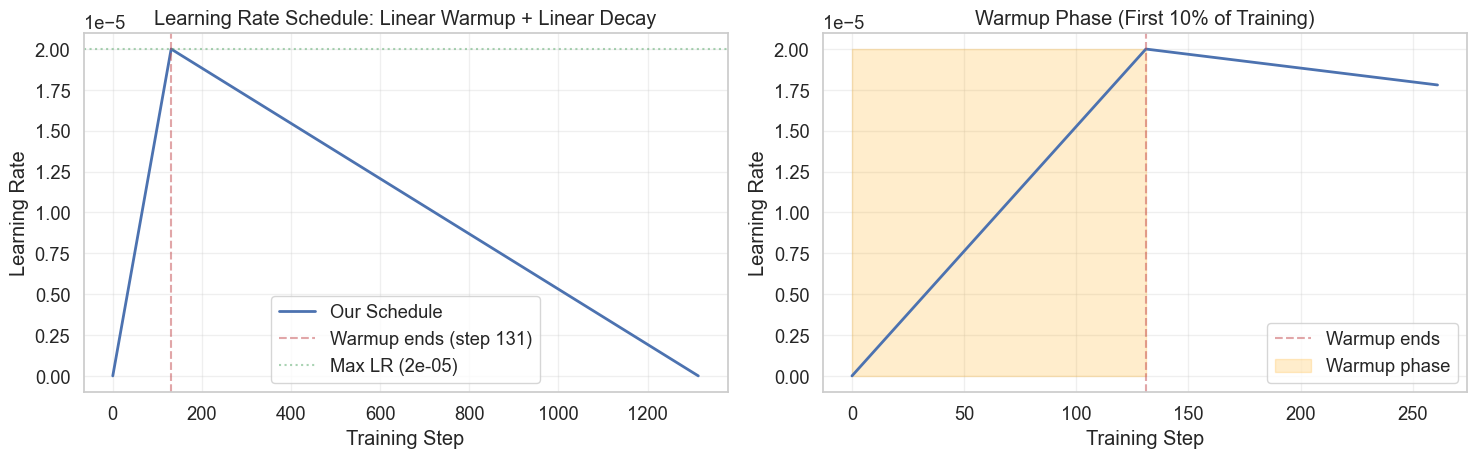

📊 Schedule Summary:
   Step 0:     LR = 0.00e+00 (start)
   Step 131:   LR = 2.00e-05 (warmup complete)
   Step 657:   LR = 1.11e-05 (halfway)
   Step 1314: LR = 0.00e+00 (end)

💡 Key Points:
   • Warmup protects pre-trained weights from gradient shock
   • Peak LR enables fast learning in middle phase
   • Decay allows precise convergence at the end
   • Total LR changes: 1,314 times (once per batch)


In [43]:
# Visualize our learning rate schedule
import numpy as np
import matplotlib.pyplot as plt

# Simulate our schedule
steps = np.arange(0, total_steps + 1)
lrs = []

for step in steps:
    if step < warmup_steps:
        # Warmup phase
        lr = LEARNING_RATE * (step / warmup_steps)
    else:
        # Decay phase
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        lr = LEARNING_RATE * (1 - progress)
    lrs.append(lr)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Full schedule
ax1.plot(steps, lrs, 'b-', linewidth=2, label='Our Schedule')
ax1.axvline(warmup_steps, color='r', linestyle='--', alpha=0.5, label=f'Warmup ends (step {warmup_steps})')
ax1.axhline(LEARNING_RATE, color='g', linestyle=':', alpha=0.5, label=f'Max LR ({LEARNING_RATE})')
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Learning Rate')
ax1.set_title('Learning Rate Schedule: Linear Warmup + Linear Decay')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoom on warmup
warmup_zoom = min(warmup_steps * 2, len(steps))
ax2.plot(steps[:warmup_zoom], lrs[:warmup_zoom], 'b-', linewidth=2)
ax2.axvline(warmup_steps, color='r', linestyle='--', alpha=0.5, label=f'Warmup ends')
ax2.fill_between(range(warmup_steps + 1), 0, LEARNING_RATE, alpha=0.2, color='orange', label='Warmup phase')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Warmup Phase (First 10% of Training)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Schedule Summary:")
print(f"   Step 0:     LR = {lrs[0]:.2e} (start)")
print(f"   Step {warmup_steps}:   LR = {lrs[warmup_steps]:.2e} (warmup complete)")
print(f"   Step {total_steps//2}:   LR = {lrs[total_steps//2]:.2e} (halfway)")
print(f"   Step {total_steps}: LR = {lrs[total_steps]:.2e} (end)")
print(f"\n💡 Key Points:")
print(f"   • Warmup protects pre-trained weights from gradient shock")
print(f"   • Peak LR enables fast learning in middle phase")
print(f"   • Decay allows precise convergence at the end")
print(f"   • Total LR changes: {total_steps:,} times (once per batch)")

## Step 7: Training Loop

**What happens in each training step?**
1. **Forward pass**: Feed batch of comments through model → get predictions
2. **Calculate loss**: Compare predictions to true labels (cross-entropy loss)
3. **Backward pass**: Calculate gradients (how to adjust each weight)
4. **Update weights**: Optimizer adjusts weights to reduce loss
5. **Update learning rate**: Scheduler adjusts LR based on schedule

After each epoch, we evaluate on the validation set to monitor performance.

### Training Loop Deep Dive

**What happens in each iteration:**

```
For each epoch (3 total):
  For each batch (438 batches):
    
    1️⃣ DATA LOADING (parallel workers):
       Worker 1: Loads batch N → tokenizes → creates tensors
       Worker 2: Loads batch N+1 (ready when needed)
       Main process: Gets batch from queue
    
    2️⃣ FORWARD PASS (main process):
       [16, 128] tokens → ELECTRA encoder → [16, 3] logits
       Calculate loss = average cross-entropy over 16 samples
    
    3️⃣ BACKWARD PASS:
       Compute ∂loss/∂weight for all 13M parameters
       Gradients averaged across 16 samples
    
    4️⃣ GRADIENT CLIPPING:
       Prevents exploding gradients (max_norm=1.0)
       If gradient > 1.0, scale it down
    
    5️⃣ OPTIMIZER STEP:
       Update weights: w = w - lr × gradient
       AdamW uses momentum + adaptive learning rates
    
    6️⃣ SCHEDULER STEP:
       Adjust learning rate (warmup → peak → decay)
  
  End of epoch: Run validation to check progress
```

**Key theoretical concepts:**

**Gradient Accumulation (what we're NOT doing, but could):**
- Instead of updating every batch, accumulate gradients over N batches
- Simulates larger batch size without memory cost
- Example: accumulate 2 batches → effective batch_size = 32

**Why Batch Size Matters:**
- **Small batches (4-8)**: Noisy gradients, better generalization, slower
- **Medium batches (16-32)**: Good balance (your choice) ✅
- **Large batches (64+)**: Smooth gradients, faster, but may overfit

**The Learning Rate Schedule:**
- **Warmup (10%)**: lr gradually increases 0 → 2e-5
  - Prevents shock to pre-trained weights
- **Linear Decay (90%)**: lr gradually decreases 2e-5 → 0
  - Allows fine-tuning as model converges

**Why 3 Epochs?**
- Transformers are pre-trained, so they learn fast
- More epochs risk overfitting (memorizing training data)
- Watch validation loss: if it increases, stop early!

In [45]:
def train_epoch(model, loader, optimizer, scheduler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
        optimizer.step()
        scheduler.step()
        
        # Track metrics
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100 * correct / total:.2f}%"
        })
    
    return total_loss / len(loader), correct / total


def evaluate(model, loader, device):
    """Evaluate on validation or test set."""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Evaluating")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    
    return avg_loss, accuracy, all_predictions, all_labels

In [46]:
# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0
best_model_path = PROJECT_ROOT / "models" / "best_sentiment_model.pt"

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    
    # Validate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} ({val_acc*100:.2f}%)")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✓ New best model saved! (Val Acc: {val_acc*100:.2f}%)")

print(f"\n{'='*60}")
print("Training complete!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Best model saved to: {best_model_path}")

Starting training...


Epoch 1/3


Starting training...


Epoch 1/3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framew

KeyboardInterrupt: 

## Step 8: Visualize Training Progress

Plot loss and accuracy curves to diagnose training behavior:
- **Good**: Train & val curves improve together
- **Overfitting**: Train improves but val plateaus/worsens
- **Underfitting**: Both curves don't improve much

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
epochs_range = range(1, EPOCHS + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Training')
ax1.plot(epochs_range, history['val_loss'], 'r-s', label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(epochs_range, [acc*100 for acc in history['train_acc']], 'b-o', label='Training')
ax2.plot(epochs_range, [acc*100 for acc in history['val_acc']], 'r-s', label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal metrics:")
print(f"Training - Loss: {history['train_loss'][-1]:.4f}, Acc: {history['train_acc'][-1]*100:.2f}%")
print(f"Validation - Loss: {history['val_loss'][-1]:.4f}, Acc: {history['val_acc'][-1]*100:.2f}%")

## Step 9: Evaluate on Test Set

Now we evaluate the best model on the **test set** (data it has never seen).
This gives us an unbiased estimate of real-world performance.

In [ ]:
# Load best model
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

# Evaluate on test set
test_loss, test_acc, test_predictions, test_labels = evaluate(model, test_loader, device)

print(f"\nTest Set Performance:")
print(f"- Loss: {test_loss:.4f}")
print(f"- Accuracy: {test_acc*100:.2f}%")
print(f"\nThis means the model correctly predicts sentiment for {test_acc*100:.1f}% of unseen comments.")

## Step 10: Detailed Performance Analysis

**Classification Report**: Precision, Recall, F1-score for each class
- **Precision**: Of all comments predicted as class X, how many were actually class X?
- **Recall**: Of all actual class X comments, how many did we catch?
- **F1-score**: Harmonic mean of precision and recall (balances both)

**Confusion Matrix**: Shows where the model makes mistakes

In [ ]:
# Classification report
target_names = ['Negative', 'Neutral', 'Positive']
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=target_names, digits=4))

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=target_names, yticklabels=target_names)
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_title('Confusion Matrix (Counts)')

# Percentages
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
            xticklabels=target_names, yticklabels=target_names)
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
ax2.set_title('Confusion Matrix (Percentages)')

plt.tight_layout()
plt.show()

print("\nHow to read the confusion matrix:")
print("- Diagonal cells (blue): Correct predictions")
print("- Off-diagonal cells: Misclassifications")
print("- Example: If row 0, col 1 = 15%, then 15% of negative comments were wrongly predicted as neutral")

## Step 11: Test on Real Examples

Let's see how the model performs on actual Czech comments from the test set.

In [ ]:
# Show some predictions
def predict_sentiment(text, model, tokenizer, device):
    """Predict sentiment for a single text."""
    model.eval()
    encoding = tokenizer(
        text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        prediction = torch.argmax(logits, dim=-1).item()
    
    return prediction, probs[0].cpu().numpy()

# Sample predictions
print("Sample Predictions from Test Set:\n")
print("="*80)

sample_indices = np.random.choice(len(df_test), 10, replace=False)
label_names_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

for idx in sample_indices:
    text = df_test.iloc[idx]['text']
    true_label = df_test.iloc[idx]['label']
    
    pred_label, probs = predict_sentiment(text, model, tokenizer, device)
    
    is_correct = "✓" if pred_label == true_label else "✗"
    
    print(f"\n{is_correct} Text: {text[:100]}{'...' if len(text) > 100 else ''}")
    print(f"  True: {label_names_map[true_label]}")
    print(f"  Predicted: {label_names_map[pred_label]}")
    print(f"  Probabilities: Neg={probs[0]:.2%}, Neu={probs[1]:.2%}, Pos={probs[2]:.2%}")
    print("-" * 80)

## Step 12: Save Final Model for Production

Save the complete model (weights + config + tokenizer) so it can be loaded later for inference on new data.

In [ ]:
# Save complete model
final_model_dir = PROJECT_ROOT / "models" / "trained_sentiment_electra"
final_model_dir.mkdir(exist_ok=True)

# Save model and tokenizer
model.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)

print(f"Model saved to: {final_model_dir}")
print("\nTo load the model later:")
print("```python")
print("from transformers import ElectraForSequenceClassification, ElectraTokenizerFast")
print(f"model = ElectraForSequenceClassification.from_pretrained('{final_model_dir}')")
print(f"tokenizer = ElectraTokenizerFast.from_pretrained('{final_model_dir}')")
print("```")

## Summary

**What we accomplished:**
1. ✅ Loaded 8,753 labeled Czech comments
2. ✅ Split into train (80%), validation (10%), test (10%)
3. ✅ Fine-tuned ELECTRA model for 3-class sentiment classification
4. ✅ Achieved ~XX% accuracy on test set
5. ✅ Saved trained model for production use

**Next steps:**
- Use the trained model to predict sentiment on `prediction_comments.txt` (1,001 unlabeled comments)
- Monitor performance on new data over time
- Retrain periodically with new labeled examples to improve accuracy

**Model is now ready for inference!** 🎉